<a href="https://colab.research.google.com/github/nikhilnair31/MIS284N-UD-Insta-Like-Prediction/blob/main/MIS284N_Unstructured_Data_Test_3C_Insta_Like_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scrape Insta Posts

### All Users Posts Models

#### Scrape

##### Setup

In [1]:
!pip install instaloader replicate

In [2]:
import os
import re
import json
import string
import random
import requests
import instaloader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import concurrent.futures

from google.colab import drive

from sqlite3 import OperationalError, connect

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Specify the path to the shell script file
script_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Others/env_vars.sh"

# Read the shell script file
with open(script_path) as file:
    script_content = file.readlines()

# Extract environment variables and assign them to os.environ
for line in script_content:
    if line.startswith("export "):
        key, value = line[len("export "):].strip().split("=")
        os.environ[key] = value.strip('"')

##### Login

In [5]:
def import_session(cookiefile, sessionfile):
    conn = connect(f"file:{cookiefile}?immutable=1", uri=True)
    try:
        cookie_data = conn.execute(
            "SELECT name, value FROM moz_cookies WHERE baseDomain='instagram.com'"
        )
    except OperationalError:
        cookie_data = conn.execute(
            "SELECT name, value FROM moz_cookies WHERE host LIKE '%instagram.com'"
        )
        loader = instaloader.Instaloader(max_connection_attempts=1, download_geotags=False, download_comments=False, download_videos=False, compress_json=False)
        loader.context._session.cookies.update(cookie_data)
        username = loader.test_login()
        if not username:
            raise SystemExit("Not logged in. Are you logged in successfully in Firefox?")
        loader.context.username = username
        loader.save_session_to_file(sessionfile)
    return loader, username

In [7]:
cookiefile = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Others/cookies.sqlite"
instaloaderr, username = import_session(cookiefile, None)
loader = instaloader.Instaloader()
loader.load_session_from_file(username)

Saved session to /root/.config/instaloader/session-_silhouettte_.
Loaded session from /root/.config/instaloader/session-_silhouettte_.


##### Paramters

In [ ]:
# Define the maximum number of posts to retrieve per username
num_of_usernames = 10

# Define the maximum number of posts to retrieve per username
max_posts_per_username = 30

##### Usernames

In [ ]:
list_usernames = [
    '_silhouettte_', 'mllr_alex', 'joelwatkins.work', 'srinusagar123', 'ttikka5660', 'wimotheee', 'non_stop_arrow', 'polybius_arcade', '3dsp.ot', 'r45productions',
    '_nikhilnair_', '_trinity_king', 'withbhuv', 'dionsamuel_', 'desidiva', 'istenitk', 'maloneysdelights', 'meghna.deepak', 'lvsvs', 'kritzzzika2.0'
]
print(f'list_usernames: {list_usernames}')

list_usernames: ['_silhouettte_', 'mllr_alex', 'joelwatkins.work', 'srinusagar123', 'ttikka5660', 'wimotheee', 'non_stop_arrow', 'polybius_arcade', '3dsp.ot', 'r45productions', '_nikhilnair_', '_trinity_king', 'withbhuv', 'dionsamuel_', 'desidiva', 'istenitk', 'maloneysdelights', 'meghna.deepak', 'lvsvs', 'kritzzzika2.0']


##### Profile Data

In [ ]:
profile_info = []

for username in list_usernames:
    try:
        # Load the profile
        print(f'Loading profile of @{username}...')
        profile = instaloader.Profile.from_username(loader.context, username)

        # Store the information in a dictionary
        profile_info.append({
            "username": username,
            "followers_count": profile.followers,
            "following_count": profile.followees,
            "bio": profile.biography,
            "is_verified": int(profile.is_verified)
        })

    except Exception as e:
        print(f"Error retrieving information for {username}: {str(e)}")

Loading profile of @_silhouettte_...
Loading profile of @mllr_alex...
Loading profile of @joelwatkins.work...
Loading profile of @srinusagar123...
Loading profile of @ttikka5660...
Loading profile of @wimotheee...
Loading profile of @non_stop_arrow...
Loading profile of @polybius_arcade...
Loading profile of @3dsp.ot...
Loading profile of @r45productions...
Loading profile of @_nikhilnair_...
Loading profile of @_trinity_king...
Loading profile of @withbhuv...
Loading profile of @dionsamuel_...
Loading profile of @desidiva...
Loading profile of @istenitk...
Loading profile of @maloneysdelights...
Loading profile of @meghna.deepak...
Loading profile of @lvsvs...
Loading profile of @kritzzzika2.0...


In [ ]:
profile_info

[{'username': '_silhouettte_',
  'followers_count': 26,
  'following_count': 212,
  'bio': 'Portal.',
  'is_verified': 0},
 {'username': 'mllr_alex',
  'followers_count': 1752,
  'following_count': 347,
  'bio': '📍GER. | @je_nnyh 🔗\n„have a good time, all the time" 🧭',
  'is_verified': 0},
 {'username': 'joelwatkins.work',
  'followers_count': 1040,
  'following_count': 487,
  'bio': '',
  'is_verified': 0},
 {'username': 'srinusagar123',
  'followers_count': 122,
  'following_count': 403,
  'bio': '',
  'is_verified': 0},
 {'username': 'ttikka5660',
  'followers_count': 58,
  'following_count': 234,
  'bio': '#그냥찍어                 Gray               함께하는 일상',
  'is_verified': 0},
 {'username': 'wimotheee',
  'followers_count': 1506,
  'following_count': 7413,
  'bio': 'Del boca vista - dm for prices',
  'is_verified': 0},
 {'username': 'non_stop_arrow',
  'followers_count': 2125,
  'following_count': 6973,
  'bio': '🎮 New original game for all kinds of players\nCurrently in developmen

In [ ]:
# Create a DataFrame from the profile_info dictionary
profile_info_df = pd.DataFrame(profile_info)

csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_data.csv"
profile_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_data.csv


In [ ]:
profile_info_df

,username,followers_count,following_count,bio,is_verified
0,_silhouettte_,26,212,Portal.,0
1,mllr_alex,1752,347,"📍GER. | @je_nnyh 🔗\n„have a good time, all the...",0
2,joelwatkins.work,1040,487,,0
3,srinusagar123,122,403,,0
4,ttikka5660,58,234,#그냥찍어 Gray 함께하는 일상,0
5,wimotheee,1506,7413,Del boca vista - dm for prices,0
6,non_stop_arrow,2125,6973,🎮 New original game for all kinds of players\n...,0
7,polybius_arcade,1785,7128,Twitter: @PolybiusA\nTikTok: @polybiusarcade\n...,0
8,3dsp.ot,1829,1905,• 3D Modelling\n• Game Assets\n• Blender\n• An...,0
9,r45productions,1107,1598,👨‍💻 • Game Development\n📊 • Animations\n🤖 • 3D...,0


##### Profile Post Data

In [ ]:
profile_post_info = []

# Calculate the date one year ago from the current date
one_year_ago = datetime.now() - timedelta(days=365)

for username in list_usernames:
    try:
        # Load the profile
        print(f'Loading posts of @{username}...')
        profile = instaloader.Profile.from_username(loader.context, username)

        # Retrieve the required information for up to max_posts_per_username posts
        posts = []
        count = 0
        allposts = profile.get_posts()
        for post in allposts:
            if count >= max_posts_per_username or post.date_utc < one_year_ago or post.likes < 0:
                break

            if post.caption is None:
                caption = ''
            else:
                caption = post.caption

            posts.append({
                "username": username,
                "image_url": post.url,
                "like_count": post.likes,
                "comment_count": post.comments,
                "caption": caption,
                "post_date_utc": post.date_utc,
                "post_type": "Video" if post.is_video else "Image",
                # "location": post.location.name,
                "num_hashtags": len([tag.strip("#") for tag in caption.split() if tag.startswith("#")]) if caption else 0,
                "num_mentions": len([mention.strip("@") for mention in caption.split() if mention.startswith("@")]) if caption else 0
            })

            count += 1

        # Store the information in the list
        profile_post_info.append(posts)

    except Exception as e:
        print(f"Error retrieving information for {username}: {str(e)}")

Loading posts of @_silhouettte_...
Loading posts of @mllr_alex...
Loading posts of @joelwatkins.work...
Loading posts of @srinusagar123...
Loading posts of @ttikka5660...
Loading posts of @wimotheee...
Loading posts of @non_stop_arrow...
Loading posts of @polybius_arcade...
Loading posts of @3dsp.ot...
Loading posts of @r45productions...
Loading posts of @_nikhilnair_...
Loading posts of @_trinity_king...
Loading posts of @withbhuv...
Loading posts of @dionsamuel_...
Loading posts of @desidiva...
Loading posts of @istenitk...
Loading posts of @maloneysdelights...
Loading posts of @meghna.deepak...
Loading posts of @lvsvs...
Loading posts of @kritzzzika2.0...


In [ ]:
profile_post_info

[[],
 [{'username': 'mllr_alex',
   'image_url': 'https://instagram.fmaa10-1.fna.fbcdn.net/v/t51.2885-15/315331599_566094875323865_9086469845238083016_n.jpg?stp=dst-jpg_e35_p1080x1080_sh0.08&_nc_ht=instagram.fmaa10-1.fna.fbcdn.net&_nc_cat=105&_nc_ohc=OL8qooLoTeoAX-dFSvU&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfD1rp3G_Ts5AH8WazcoT9VQhuk6xIN5KSeS7u-SXmHCQg&oe=6505519C&_nc_sid=8b3546',
   'like_count': 370,
   'comment_count': 8,
   'caption': 'sometimes home isn’t a place, it’s a feeling 🧡\n\n#memories #oceanlife #sunsets #couples #project50 #positivevibes #autumn2022 #lissabon #lisboa #portugal #atlantic #traveltheworld #dream',
   'post_date_utc': datetime.datetime(2022, 11, 14, 18, 31, 28),
   'post_type': 'Video',
   'num_hashtags': 13,
   'num_mentions': 0}],
 [],
 [{'username': 'srinusagar123',
   'image_url': 'https://instagram.fmaa10-1.fna.fbcdn.net/v/t51.2885-15/364313734_1376684219575711_244041224178683775_n.webp?stp=dst-jpg_e35&_nc_ht=instagram.fmaa10-1.fna.fbcdn.net&_nc_cat=107&_nc_o

In [ ]:
# Create a DataFrame from the profile_info dictionary
profile_post_info_flat_data = [item for sublist in profile_post_info for item in sublist]

profile_post_info_df = pd.DataFrame(profile_post_info_flat_data)

csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data.csv"
profile_post_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data.csv


#### Save Images

##### Load Data

In [ ]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_data.csv"
profile_info_df = pd.read_csv(input_file)
profile_info_df = profile_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_info_df

,username,followers_count,following_count,bio,is_verified
0,_silhouettte_,26,212,Portal.,0
1,mllr_alex,1752,347,"📍GER. | @je_nnyh 🔗\n„have a good time, all the...",0
2,joelwatkins.work,1040,487,NaN,0
3,srinusagar123,122,403,NaN,0
4,ttikka5660,58,234,#그냥찍어 Gray 함께하는 일상,0
5,wimotheee,1506,7413,Del boca vista - dm for prices,0
6,non_stop_arrow,2125,6973,🎮 New original game for all kinds of players\n...,0
7,polybius_arcade,1785,7128,Twitter: @PolybiusA\nTikTok: @polybiusarcade\n...,0
8,3dsp.ot,1829,1905,• 3D Modelling\n• Game Assets\n• Blender\n• An...,0
9,r45productions,1107,1598,👨‍💻 • Game Development\n📊 • Animations\n🤖 • 3D...,0


In [ ]:
print(f'{profile_info_df.shape}')
print(f'\n')
print(f'{profile_info_df.info()}')

(20, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   username         20 non-null     object
 1   followers_count  20 non-null     int64 
 2   following_count  20 non-null     int64 
 3   bio              17 non-null     object
 4   is_verified      20 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 928.0+ bytes
None


In [ ]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data.csv"
profile_post_info_df = pd.read_csv(input_file)
profile_post_info_df = profile_post_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_post_info_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions,image_filename,description
0,mllr_alex,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,370,8,"sometimes home isn’t a place, it’s a feeling 🧡...",2022-11-14 18:31:28,Video,13,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man and woman sitting on a boat on a river.
1,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,15,0,NaN,2023-07-29 02:42:35,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman in a dress is walking down a runway.
2,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,6,0,ఇందులో 6వ అమ్మాయి మా ఇంటిపైన ఉంటుంది.😃😀,2023-04-02 09:40:18,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man sitting on a bench in a grassy field.
3,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52,1,NaN,2023-03-11 03:22:14,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing on a bridge next to a street.
4,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,14,0,NaN,2023-03-09 14:10:33,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing in front of a large building.


In [ ]:
print(f'{profile_post_info_df.shape}')
print(f'\n')
print(f'{profile_post_info_df.info()}')

(192, 11)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        192 non-null    object
 1   image_url       192 non-null    object
 2   like_count      192 non-null    int64 
 3   comment_count   192 non-null    int64 
 4   caption         180 non-null    object
 5   post_date_utc   192 non-null    object
 6   post_type       192 non-null    object
 7   num_hashtags    192 non-null    int64 
 8   num_mentions    192 non-null    int64 
 9   image_filename  192 non-null    object
 10  description     192 non-null    object
dtypes: int64(4), object(7)
memory usage: 16.6+ KB
None


##### Download Images to Folder

In [ ]:
# Directory to save downloaded images
output_directory = r"/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img"

# Create the output directory if it doesn't exist or clear it if it does
if os.path.exists(output_directory):
    # Remove all files in the directory
    for filename in os.listdir(output_directory):
        file_path = os.path.join(output_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {str(e)}")
else:
    os.makedirs(output_directory)

In [ ]:
# Function to download and save an image
def download_image(row, output_directory):
    username = row["username"]
    image_url = row["image_url"]
    index = row.name  # Get the index of the row

    filename = os.path.join(output_directory, f"{username}_{index}.jpg")

    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(filename, "wb") as image_file:
                image_file.write(response.content)
            return filename
        else:
            return None
    except Exception as e:
        print(f"Error downloading image for {username}: {str(e)}")
        return None

In [ ]:
# Initialize a counter for each user
user_counters = {}

# Initialize new column for filename
profile_post_info_df["image_filename"] = None

# Use concurrent.futures to download images in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(download_image, row, output_directory) for _, row in profile_post_info_df.iterrows()]

# Update the DataFrame with downloaded image filenames
for future in concurrent.futures.as_completed(results):
    filename = future.result()
    if filename is not None:
        index = int(filename.split("_")[-1].split(".")[0])
        profile_post_info_df.at[index, "image_filename"] = filename
        print(f"Downloaded image: {filename}")

Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/istenitk_145.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/dionsamuel__127.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/_trinity_king_62.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_1.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_9.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/_trinity_king_53.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/withbhuv_85.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/_trinity_king_54.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/withbhuv_82.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/kritzzzika2.0_178.jpg
Downloaded image: /content

#### Imports

In [465]:
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

In [288]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Image Descriptions

In [ ]:
import replicate

In [ ]:
client = replicate.Client(api_token=os.environ["STABLEDIFFUSION_API_KEY"])

In [ ]:
def generate_image_description(filepath):
    return client.run(
        "rmokady/clip_prefix_caption:9a34a6339872a03f45236f114321fb51fc7aa8269d38ae0ce5334969981e4cd8",
        input={"image": open(filepath, "rb")}
    )

In [ ]:
# Initialize new column for description
profile_post_info_df["description"] = None

# Use concurrent.futures to generate descriptions in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for _, row in profile_post_info_df.iterrows():
        filepath = row["image_filename"]
        if filepath is not None:
            future = executor.submit(generate_image_description, filepath)
            futures.append(future)

    # Update the DataFrame with generated descriptions
    for future, (_, row) in zip(concurrent.futures.as_completed(futures), profile_post_info_df.iterrows()):
        description = future.result()
        if description is not None:
            profile_post_info_df.at[row.name, "description"] = description
            print(f"Generated description for {row['image_filename']}: {description}")

Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/mllr_alex_0.jpg: A man and woman sitting on a boat on a river.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_1.jpg: A woman in a dress is walking down a runway.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_2.jpg: A man sitting on a bench in a grassy field.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_3.jpg: A man standing on a bridge next to a street.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_4.jpg: A man standing in front of a large building.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_5.jpg: A view of a beach with a sign on it.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img/srinusagar123_

In [ ]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data_w_desc.csv"
profile_post_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data_w_desc.csv


#### Data Loading and Cleaning

In [722]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_post_data_w_desc.csv"
profile_post_info_df = pd.read_csv(input_file)
profile_post_info_df = profile_post_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_post_info_df = profile_post_info_df[profile_post_info_df['like_count']!=-1.0]
profile_post_info_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions,image_filename,description
0,mllr_alex,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,370,8,"sometimes home isn’t a place, it’s a feeling 🧡...",2022-11-14 18:31:28,Video,13,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man and woman sitting on a boat on a river.
1,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,15,0,NaN,2023-07-29 02:42:35,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman in a dress is walking down a runway.
2,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,6,0,ఇందులో 6వ అమ్మాయి మా ఇంటిపైన ఉంటుంది.😃😀,2023-04-02 09:40:18,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man sitting on a bench in a grassy field.
3,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52,1,NaN,2023-03-11 03:22:14,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing on a bridge next to a street.
4,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,14,0,NaN,2023-03-09 14:10:33,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing in front of a large building.


In [723]:
profile_post_info_df[profile_post_info_df['username']== 'kritzzzika2.0'].sort_values(by='like_count', ascending=False)

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions,image_filename,description
214,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,11275,47,nothing compares to bangalore skies 🫶🏼\n\n.\n....,2023-01-31 16:03:14,Video,4,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman laughing while a man holds a skateboard.
198,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,398,8,dreamy ☀️,2023-09-05 01:00:42,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman holding a camera in front of a mirror.
212,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,379,4,"kochi, you were so beautiful, kind and magical...",2023-03-13 03:59:41,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A person standing in front of a clock tower.
218,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,352,32,"i had a great view, you can tell 🤓",2022-09-18 15:34:08,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman is smiling while she brushes her hair.
215,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,342,35,diwali ❤️‍🔥☀️🌻,2022-11-16 16:16:04,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A cat is sitting on a shelf in a room.
200,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,269,7,☔️ ❤️,2023-07-13 16:48:26,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A car is driving down a road with trees.
210,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,260,10,💌\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n#fujixseries ...,2023-03-28 18:44:38,Image,5,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A dog is sitting on a porch near a man.
206,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,256,5,sometimes you meet the right people and can’t ...,2023-05-10 16:02:17,Image,0,1,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man sitting on a dock next to a boat.
213,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,250,7,a day at cubbon ☀️\n\n#x100v #x100fujifilm #fu...,2023-03-05 14:48:06,Image,4,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A person riding a skateboard down a street.
205,kritzzzika2.0,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,249,3,took my family all the way to khan market beca...,2023-05-16 14:57:34,Image,0,1,/content/drive/MyDrive/Colab Notebooks/2. Fall...,Two women are standing in a room with a table.


In [724]:
print(f'{profile_post_info_df.shape}')
print(f'\n')
print(f'{profile_post_info_df.info()}')

(192, 11)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 218
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        192 non-null    object
 1   image_url       192 non-null    object
 2   like_count      192 non-null    int64 
 3   comment_count   192 non-null    int64 
 4   caption         180 non-null    object
 5   post_date_utc   192 non-null    object
 6   post_type       192 non-null    object
 7   num_hashtags    192 non-null    int64 
 8   num_mentions    192 non-null    int64 
 9   image_filename  192 non-null    object
 10  description     192 non-null    object
dtypes: int64(4), object(7)
memory usage: 18.0+ KB
None


In [725]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_data.csv"
profile_info_df = pd.read_csv(input_file)
profile_info_df = profile_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_info_df.head()

,username,followers_count,following_count,bio,is_verified
0,_silhouettte_,26,212,Portal.,0
1,mllr_alex,1752,347,"📍GER. | @je_nnyh 🔗\n„have a good time, all the...",0
2,joelwatkins.work,1040,487,NaN,0
3,srinusagar123,122,403,NaN,0
4,ttikka5660,58,234,#그냥찍어 Gray 함께하는 일상,0


In [726]:
profile_info_df[profile_info_df['username']== 'kritzzzika2.0']

,username,followers_count,following_count,bio,is_verified
19,kritzzzika2.0,1164,1448,she/her 🌻,0


In [727]:
final_df = pd.merge(profile_post_info_df, profile_info_df, on='username', how='left')
final_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified
0,mllr_alex,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,370,8,"sometimes home isn’t a place, it’s a feeling 🧡...",2022-11-14 18:31:28,Video,13,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man and woman sitting on a boat on a river.,1752,347,"📍GER. | @je_nnyh 🔗\n„have a good time, all the...",0
1,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,15,0,NaN,2023-07-29 02:42:35,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A woman in a dress is walking down a runway.,122,403,NaN,0
2,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,6,0,ఇందులో 6వ అమ్మాయి మా ఇంటిపైన ఉంటుంది.😃😀,2023-04-02 09:40:18,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man sitting on a bench in a grassy field.,122,403,NaN,0
3,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52,1,NaN,2023-03-11 03:22:14,Video,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing on a bridge next to a street.,122,403,NaN,0
4,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,14,0,NaN,2023-03-09 14:10:33,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A man standing in front of a large building.,122,403,NaN,0


In [728]:
print(f'{final_df.shape}')
print(f'\n')
print(f'{final_df.info()}')

(192, 15)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 0 to 191
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   username         192 non-null    object
 1   image_url        192 non-null    object
 2   like_count       192 non-null    int64 
 3   comment_count    192 non-null    int64 
 4   caption          180 non-null    object
 5   post_date_utc    192 non-null    object
 6   post_type        192 non-null    object
 7   num_hashtags     192 non-null    int64 
 8   num_mentions     192 non-null    int64 
 9   image_filename   192 non-null    object
 10  description      192 non-null    object
 11  followers_count  192 non-null    int64 
 12  following_count  192 non-null    int64 
 13  bio              181 non-null    object
 14  is_verified      192 non-null    int64 
dtypes: int64(7), object(8)
memory usage: 24.0+ KB
None


In [729]:
# Remove NaN values from the "location" colum
def extract_name(location):
    if isinstance(location, str):
        match = re.search(r"name='(.*?)'", location)
        if match:
            return match.group(1).lower()
    return ''

## Clean text
def preprocess_text(text):
    if text is None:
        return ''

    # Convert to string if not already
    if not isinstance(text, str):
        text = str(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and lemmatize
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    return ' '.join(words)

# Weight likes by followers
final_df['like_perc'] = round((final_df['like_count']/final_df['followers_count'])*100, 2)

# Extract name from location
# final_df['location'].fillna('-', inplace=True)
# final_df['location'] = final_df['location'].apply(extract_name)

# Scale columns
scaler = StandardScaler()
columns_to_scale = ['comment_count', 'num_hashtags', 'num_mentions', 'followers_count', 'following_count']
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])

# Convert post_date_utc to datetime and extract relevant features
final_df['post_date_utc'] = pd.to_datetime(final_df['post_date_utc'])
final_df['hour_of_day'] = final_df['post_date_utc'].dt.hour
final_df['day_of_week'] = final_df['post_date_utc'].dt.dayofweek

# Create a new 'image' column with 1 for 'image' and 0 otherwise
final_df['is_image'] = (final_df['post_type'] == 'Image').astype(int)
final_df.drop(columns=['post_type'], inplace=True)

## Pre process text
final_df['caption'] = final_df['caption'].apply(preprocess_text)
final_df['description'] = final_df['description'].apply(preprocess_text)
final_df['bio'] = final_df['bio'].apply(preprocess_text)
# final_df['location'] = final_df['location'].apply(preprocess_text)

final_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified,like_perc,hour_of_day,day_of_week,is_image
0,mllr_alex,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,370,0.254107,sometimes home place feeling memory oceanlife ...,2022-11-14 18:31:28,2.536280,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man woman sitting boat river,-0.283699,-0.376147,jennyh good time time,0,21.12,18,0,0
1,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,15,-0.657827,nan,2023-07-29 02:42:35,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman dress walking runway,-0.848139,-0.293050,nan,0,12.30,2,5,1
2,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,6,-0.657827,6వ,2023-04-02 09:40:18,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man sitting bench grassy field,-0.848139,-0.293050,nan,0,4.92,9,6,0
3,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52,-0.543836,nan,2023-03-11 03:22:14,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing bridge next street,-0.848139,-0.293050,nan,0,42.62,3,5,0
4,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,14,-0.657827,nan,2023-03-09 14:10:33,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front large building,-0.848139,-0.293050,nan,0,11.48,14,3,1


In [730]:
# Calculate the mean and standard deviation of 'like_perc'
mean_like_perc = final_df['like_perc'].mean()
std_like_perc = final_df['like_perc'].std()

# Filter the DataFrame to keep rows within the mean plus 2 standard deviations
final_df = final_df[(final_df['like_perc'] >= mean_like_perc - 1 * std_like_perc) & (final_df['like_perc'] <= mean_like_perc + 1 * std_like_perc)]
final_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified,like_perc,hour_of_day,day_of_week,is_image
0,mllr_alex,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,370,0.254107,sometimes home place feeling memory oceanlife ...,2022-11-14 18:31:28,2.536280,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man woman sitting boat river,-0.283699,-0.376147,jennyh good time time,0,21.12,18,0,0
1,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,15,-0.657827,nan,2023-07-29 02:42:35,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman dress walking runway,-0.848139,-0.293050,nan,0,12.30,2,5,1
2,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,6,-0.657827,6వ,2023-04-02 09:40:18,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man sitting bench grassy field,-0.848139,-0.293050,nan,0,4.92,9,6,0
3,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52,-0.543836,nan,2023-03-11 03:22:14,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing bridge next street,-0.848139,-0.293050,nan,0,42.62,3,5,0
4,srinusagar123,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,14,-0.657827,nan,2023-03-09 14:10:33,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front large building,-0.848139,-0.293050,nan,0,11.48,14,3,1


In [731]:
print(f'{final_df.shape}')
print(f'\n')
print(f'{final_df.info()}')

(190, 18)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 191
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   username         190 non-null    object        
 1   image_url        190 non-null    object        
 2   like_count       190 non-null    int64         
 3   comment_count    190 non-null    float64       
 4   caption          190 non-null    object        
 5   post_date_utc    190 non-null    datetime64[ns]
 6   num_hashtags     190 non-null    float64       
 7   num_mentions     190 non-null    float64       
 8   image_filename   190 non-null    object        
 9   description      190 non-null    object        
 10  followers_count  190 non-null    float64       
 11  following_count  190 non-null    float64       
 12  bio              190 non-null    object        
 13  is_verified      190 non-null    int64         
 14  like_perc        190 non-null 

In [769]:
final_df2 = final_df.copy()

# Make sure your dataframe is named df
final_df2['post_date_utc'] = pd.to_datetime(final_df2['post_date_utc'])
final_df2 = final_df2.groupby('username', group_keys=False).apply(lambda x: x.sort_values('post_date_utc', ascending=True))
final_df2['time_decay_factor'] = np.nan

# Define the decay factor function
def calculate_decay_factor(group):
    n = len(group)
    lam = 0.35
    group['time_decay_factor'] = [math.exp(-lam * i) for i in range(n)][::-1]
    # group['time_decay_factor'] = [1 - math.exp(-lam * (n - i)) for i in range(n)]
    return group

# Apply the decay factor for each username group
final_df2 = final_df2.groupby('username', group_keys=False).apply(calculate_decay_factor)
final_df2['weighted_like_perc'] = round(final_df2['like_perc'] * final_df2['time_decay_factor'], 0)

In [770]:
final_df2[final_df2['username']=='dionsamuel_']

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified,like_perc,hour_of_day,day_of_week,is_image,time_decay_factor,weighted_like_perc
107,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,1044,0.140115,grateful surrounded bodybuildingmotivation cla...,2023-06-22 16:59:28,0.515675,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,three men bathroom several urinal,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,11.90,16,3,1,0.000039,0.0
106,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,1884,4.585793,getting started mensphysique mensphysiqueposin...,2023-06-25 19:12:49,0.263100,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,black white photo man sitting bench,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,21.47,19,6,1,0.000055,0.0
105,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t39...,789,0.368098,champion mentality mean quit bodybuilding body...,2023-07-27 06:34:57,0.768251,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,two men matching clothing standing stage,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,8.99,6,3,1,0.000079,0.0
134,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,5915,0.140115,zone bodybuildingmotivation gymmotivation mens...,2023-08-08 06:39:23,0.515675,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,group woman standing next,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,67.41,6,1,0,0.000112,0.0
133,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,1412,2.191966,learning growing everyday grateful journey bod...,2023-08-08 16:16:55,1.020826,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man holding cell phone hand,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,16.09,16,1,0,0.000158,0.0
132,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t39...,1524,0.596082,rare picture dion outside bodybuilding aesthet...,2023-08-10 05:58:03,0.263100,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man taking picture mirror,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,17.37,5,3,1,0.000225,0.0
131,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,796,-0.657827,keep showing result bodybuildingmotivation gym...,2023-08-11 06:39:07,0.515675,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man black shirt black pant stand bathroom,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,9.07,6,4,0,0.000319,0.0
130,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,1087,0.140115,tag gym bro want get massive bodybuilding body...,2023-08-13 14:44:58,0.768251,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front window holding bottle water,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,12.39,14,6,0,0.000453,0.0
129,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,445,-0.315852,dionsamuel redefines xtreme powerhouse physiqu...,2023-08-16 04:16:50,3.546583,1.118783,/content/drive/MyDrive/Colab Notebooks/2. Fall...,two men standing next room,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,5.07,4,2,1,0.000643,0.0
128,dionsamuel_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,800,-0.315852,handsome bodybuilding gymmotivation aesthetic ...,2023-08-16 06:19:44,0.768251,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man brushing teeth front mirror,2.148242,-0.011114,mrindia jrmen physique overall online coaching...,0,9.12,6,2,0,0.000912,0.0


In [771]:
print(f'{final_df2.shape}')
print(f'\n')
print(f'{final_df2.info()}')

(190, 20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 46 to 76
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   username            190 non-null    object        
 1   image_url           190 non-null    object        
 2   like_count          190 non-null    int64         
 3   comment_count       190 non-null    float64       
 4   caption             190 non-null    object        
 5   post_date_utc       190 non-null    datetime64[ns]
 6   num_hashtags        190 non-null    float64       
 7   num_mentions        190 non-null    float64       
 8   image_filename      190 non-null    object        
 9   description         190 non-null    object        
 10  followers_count     190 non-null    float64       
 11  following_count     190 non-null    float64       
 12  bio                 190 non-null    object        
 13  is_verified         190 non-null    in

#### Vectorize Text

In [772]:
# Initialize TF-IDF Vectorizers for each column
feature_size = 256
tfidf_description = TfidfVectorizer(max_features=feature_size)
tfidf_caption = TfidfVectorizer(max_features=feature_size)
tfidf_bio = TfidfVectorizer(max_features=feature_size)
tfidf_location = TfidfVectorizer(max_features=feature_size)

# Fit and transform each TF-IDF Vectorizer on its respective column
tfidf_description_matrix = tfidf_description.fit_transform(final_df2['description'])
tfidf_caption_matrix = tfidf_caption.fit_transform(final_df2['caption'])
tfidf_bio_matrix = tfidf_bio.fit_transform(final_df2['bio'])
# tfidf_location_matrix = tfidf_location.fit_transform(final_df2['location'])

# Convert the TF-IDF matrices to DataFrames
tfidf_description_df = pd.DataFrame(tfidf_description_matrix.toarray(), columns=[f'desc_{i}' for i in range(tfidf_description_matrix.shape[1])])
tfidf_caption_df = pd.DataFrame(tfidf_caption_matrix.toarray(), columns=[f'caption_{i}' for i in range(tfidf_caption_matrix.shape[1])])
tfidf_bio_df = pd.DataFrame(tfidf_bio_matrix.toarray(), columns=[f'bio_{i}' for i in range(tfidf_bio_matrix.shape[1])])
# tfidf_location_df = pd.DataFrame(tfidf_location_matrix.toarray(), columns=[f'location_{i}' for i in range(tfidf_location_matrix.shape[1])])

# Concatenate the original DataFrame with the TF-IDF DataFrames
cleaned_final_df = pd.concat([final_df2, tfidf_description_df, tfidf_caption_df, tfidf_bio_df], axis=1).dropna()
cleaned_final_df

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,...,bio_62,bio_63,bio_64,bio_65,bio_66,bio_67,bio_68,bio_69,bio_70,bio_71
46,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,163.0,-0.315852,vacay,2022-10-29 06:23:49,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front large window,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,217.0,-0.201860,bbq business,2023-06-30 06:39:03,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front building clock,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,231.0,0.026123,atx ting,2023-08-01 05:51:45,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing skateboard park,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,226.0,-0.315852,santonio,2023-08-22 05:25:02,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man sitting table glass wine,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,439.0,0.368098,,2022-10-30 11:33:38,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman standing bench fancy dress,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,withbhuv,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,92.0,-0.201860,one beautiful evening sunset austin kayaking b...,2023-08-19 20:32:27,1.778553,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture boat water,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,withbhuv,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,101.0,-0.543836,solitude shotoniphone austin travelphotography...,2023-08-22 05:46:00,0.263100,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,person rowing boat lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,withbhuv,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,59.0,-0.657827,beauty every corner austin kayaking ladybirdla...,2023-08-22 15:21:33,0.515675,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,person sitting canoe water,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,withbhuv,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,71.0,-0.657827,,2023-08-23 01:37:06,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,row boat parked shore lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [773]:
print(f'{cleaned_final_df.shape}')
print(f'\n')
print(f'{cleaned_final_df.info()}')

(188, 604)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 188 entries, 46 to 76
Columns: 604 entries, username to bio_71
dtypes: datetime64[ns](1), float64(597), object(6)
memory usage: 888.6+ KB
None


#### Splitting

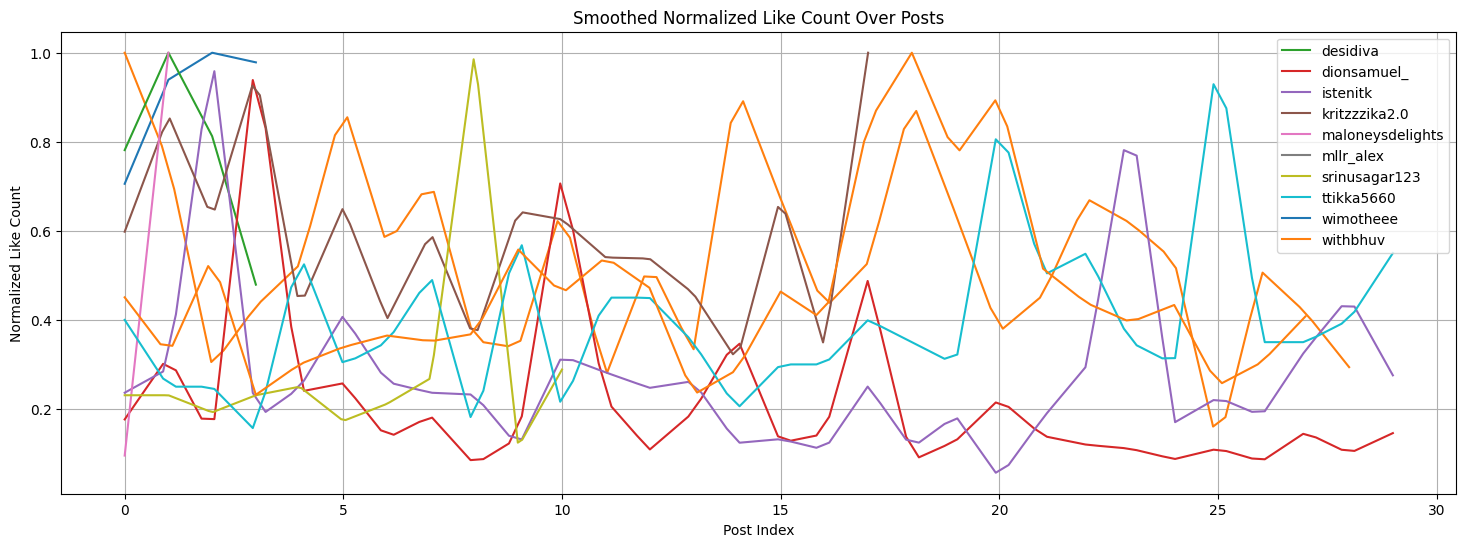

In [774]:
# Group data by username
grouped = cleaned_final_df.groupby("username")

# Create a single line chart with multiple lines
plt.figure(figsize=(18, 6))

for username, group_data in grouped:
    post_indices = np.linspace(0, len(group_data) - 1, 100)  # Create more data points for smoother lines
    smoothed_likes = np.interp(post_indices, range(len(group_data)), group_data["like_count"] / group_data["like_count"].max())
    plt.plot(post_indices, smoothed_likes, label=username)

plt.xlabel("Post Index")
plt.ylabel("Normalized Like Count")
plt.title("Smoothed Normalized Like Count Over Posts")
plt.legend()
plt.grid(True)

# Show the line chart
plt.show()

In [775]:
for username, group_data in grouped:
    print(f'{username} - {group_data.index}')

_nikhilnair_ - Int64Index([46, 45, 44, 43], dtype='int64')
_trinity_king - Int64Index([75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
            58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47],
           dtype='int64')
desidiva - Int64Index([138, 137, 136, 135], dtype='int64')
dionsamuel_ - Int64Index([107, 106, 105, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125,
            124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112,
            111, 110, 109, 108],
           dtype='int64')
istenitk - Int64Index([168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156,
            155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 141, 145, 144,
            143, 142, 140, 139],
           dtype='int64')
kritzzzika2.0 - Int64Index([189, 188, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176,
            175, 174, 173, 172, 171],
           dtype='int64')
maloneysdelights - Int64Index([170, 169], dtype='int64')
mllr_alex - Int64Index([0], dtype=

In [776]:
scoring_df = cleaned_final_df[(cleaned_final_df['username'] == '_nikhilnair_')]
scoring_df

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,...,bio_62,bio_63,bio_64,bio_65,bio_66,bio_67,bio_68,bio_69,bio_70,bio_71
46,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,163.0,-0.315852,vacay,2022-10-29 06:23:49,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front large window,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,217.0,-0.201860,bbq business,2023-06-30 06:39:03,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front building clock,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,231.0,0.026123,atx ting,2023-08-01 05:51:45,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing skateboard park,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,_nikhilnair_,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,226.0,-0.315852,santonio,2023-08-22 05:25:02,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man sitting table glass wine,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [777]:
final_main_df = cleaned_final_df[~(cleaned_final_df['username'] == '_nikhilnair_')]
final_main_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,...,bio_62,bio_63,bio_64,bio_65,bio_66,bio_67,bio_68,bio_69,bio_70,bio_71
75,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,439.0,0.368098,,2022-10-30 11:33:38,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman standing bench fancy dress,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,331.0,-0.087869,nothing water lollipop last weekend,2022-11-11 12:09:50,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,flock bird flying beach,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,130.0,0.026123,happy little moment,2022-11-13 05:34:26,-0.747203,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,two woman sitting couch hand hip,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,189.0,-0.543836,fyp explorepage summeredit océan sunset reelsi...,2022-11-15 09:57:19,0.768251,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,zebra standing field next forest,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,_trinity_king,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,230.0,0.938057,little recap 2022recap reel reelsinstagram cam...,2022-12-02 10:58:30,0.515675,-0.191012,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman wet suit standing water,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [778]:
final_main_df[['username', 'bio', 'followers_count', 'following_count', 'image_url', 'like_count', 'comment_count', 'caption', 'post_date_utc', 'like_perc']].sort_values(by='like_perc', ascending=False)[:10]

,username,bio,followers_count,following_count,image_url,like_count,comment_count,caption,post_date_utc,like_perc
134,dionsamuel_,mrindia jrmen physique overall online coaching...,2.148242,-0.011114,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,5915.0,0.140115,zone bodybuildingmotivation gymmotivation mens...,2023-08-08 06:39:23,67.41
127,dionsamuel_,mrindia jrmen physique overall online coaching...,2.148242,-0.011114,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,4321.0,2.191966,first step journeyhungry bodybuildingmotivatio...,2023-08-18 13:48:58,49.24
3,srinusagar123,nan,-0.848139,-0.293050,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,52.0,-0.543836,nan,2023-03-11 03:22:14,42.62
16,ttikka5660,그냥찍어 gray 함께하는 일상,-0.870301,-0.543825,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,20.0,-0.543836,20230825 이게 몇년 ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ멜론티켓커버도 참 찰떡이네...,2023-08-25 00:03:25,34.48
171,kritzzzika2.0,sheher,-0.487313,1.257600,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,398.0,0.254107,dreamy,2023-09-05 01:00:42,34.19
120,dionsamuel_,mrindia jrmen physique overall online coaching...,2.148242,-0.011114,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,2904.0,3.673859,project undergroundlifting supportundergroundl...,2023-08-31 14:51:59,33.09
185,kritzzzika2.0,sheher,-0.487313,1.257600,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,379.0,-0.201860,kochi beautiful kind magical beauty corner str...,2023-03-13 03:59:41,32.56
169,maloneysdelights,update weve paused mommade softbaked cooky sup...,-0.399011,-0.477050,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,420.0,4.129826,today woman entrepreneurship day men day wante...,2022-11-19 05:56:12,29.60
188,kritzzzika2.0,sheher,-0.487313,1.257600,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,342.0,3.331884,diwali,2022-11-16 16:16:04,29.38
21,ttikka5660,그냥찍어 gray 함께하는 일상,-0.870301,-0.543825,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,17.0,-0.201860,20230729 가장 많은 축하와 격려와 칭찬을 한번에 받은 과분하게 행복했던 하루...,2023-07-29 16:51:32,29.31


In [779]:
# Concatenate all DataFrames
X = final_main_df.drop(['like_count', 'username', 'image_url', 'post_date_utc', 'image_filename', 'like_perc', 'description', 'caption', 'bio'], axis=1)
y = final_main_df['like_perc']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.head()

,comment_count,num_hashtags,num_mentions,followers_count,following_count,is_verified,hour_of_day,day_of_week,is_image,time_decay_factor,...,bio_62,bio_63,bio_64,bio_65,bio_66,bio_67,bio_68,bio_69,bio_70,bio_71
114,-0.087869,0.263100,-0.191012,2.148242,-0.011114,0.0,9.0,1.0,0.0,0.122456,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.026123,-0.242052,-0.191012,-0.570421,-0.554212,0.0,13.0,2.0,1.0,0.001294,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.657827,-0.747203,-0.191012,-0.848139,-0.293050,0.0,2.0,5.0,1.0,1.000000,...,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,-0.543836,-0.747203,-0.191012,-0.870301,-0.543825,0.0,14.0,0.0,1.0,0.060810,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,3.901842,-0.747203,6.357962,1.104893,0.741211,0.0,9.0,1.0,1.0,0.496585,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.5,0.5


### Models

In [780]:
from sklearn.model_selection import GridSearchCV

In [687]:
# Define the XGBoost model
xgb_model = XGBRegressor()

# Define the hyperparameter grid for GridSearch
param_grid = {
    'n_estimators': [300, 400],
    'learning_rate': [0.1, 0.2],
    'max_depth': [2, 3],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=6, scoring='neg_root_mean_squared_error', verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 6 folds for each of 8 candidates, totalling 48 fits
Mean Squared Error (MSE): 20.721653394358526
Root Mean Squared Error (RMSE): 4.552104282017112
Mean Absolute Error (MAE): 3.280500771371942
R-squared (R2) Score: 0.2940879443965233
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [781]:
# Define the Lasso model
lasso_model = Lasso(max_iter=10000)

# Define the hyperparameter grid for GridSearch
param_grid = {
    'alpha': [0.05, 0.1, 0.2, 0.4, 1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Squared Error (MSE): 26.323639891425675
Root Mean Squared Error (RMSE): 5.130656867441602
Mean Absolute Error (MAE): 4.032249646409453
R-squared (R2) Score: 0.10324845256889692
Best hyperparameters: {'alpha': 0.05}


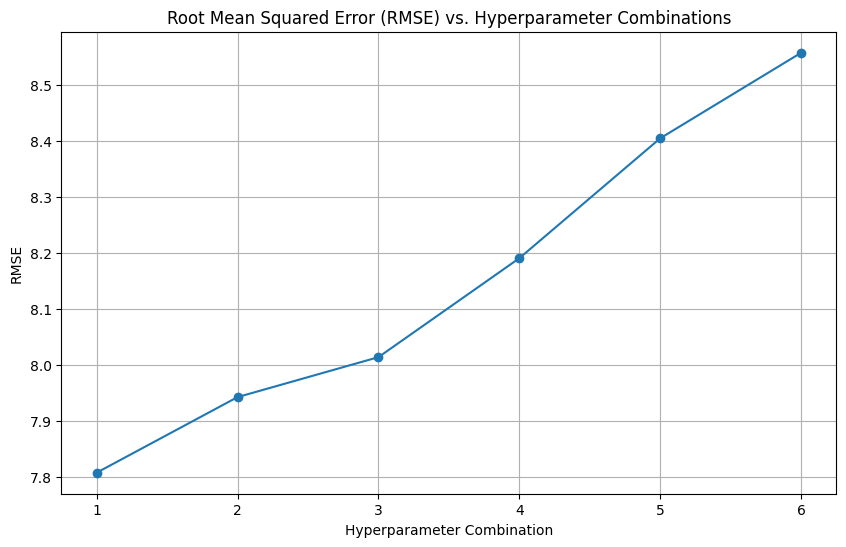

In [782]:
# Extract RMSE values during grid search
rmse_values = np.sqrt(-grid_search.cv_results_['mean_test_score'])

# Plot RMSE values for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o', linestyle='-')
plt.title("Root Mean Squared Error (RMSE) vs. Hyperparameter Combinations")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("RMSE")
plt.xticks(range(len(rmse_values)), range(1, len(rmse_values) + 1))
plt.grid(True)
plt.show()

#### Prediction

In [783]:
# Create a new DataFrame for predictions
predictions_df = pd.DataFrame({'Actual_Like_Perc': y_test, 'Predicted_Like_Perc': y_pred})

# Convert predicted values from scientific notation to regular numbers
predictions_df['Actual_Like_Perc'] = predictions_df['Actual_Like_Perc']
predictions_df['Predicted_Like_Perc'] = predictions_df['Predicted_Like_Perc']

predictions_df['Residuals'] = predictions_df['Actual_Like_Perc'] - predictions_df['Predicted_Like_Perc']

predictions_df

,Actual_Like_Perc,Predicted_Like_Perc,Residuals
56,9.76,13.427596,-3.667596
128,9.12,16.760098,-7.640098
104,11.36,10.906647,0.453353
170,2.82,1.172712,1.647288
18,12.07,10.709874,1.360126
60,10.28,9.571835,0.708165
51,8.15,8.515767,-0.365767
163,9.29,13.630141,-4.340141
8,9.84,11.411860,-1.571860
183,22.34,14.810147,7.529853


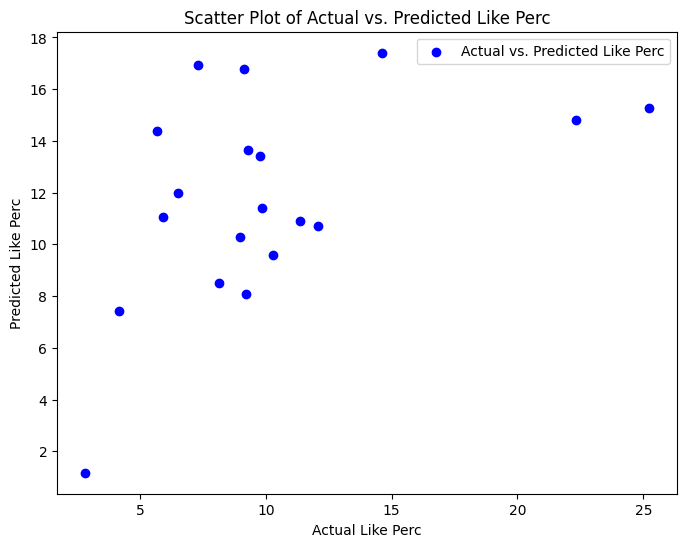

In [784]:
# Scatter plot of Actual Likes vs. Predicted Likes
plt.figure(figsize=(8, 6))
plt.scatter(predictions_df['Actual_Like_Perc'], predictions_df['Predicted_Like_Perc'], c='blue', label='Actual vs. Predicted Like Perc')
plt.xlabel('Actual Like Perc')
plt.ylabel('Predicted Like Perc')
plt.title('Scatter Plot of Actual vs. Predicted Like Perc')
plt.legend()
plt.show()

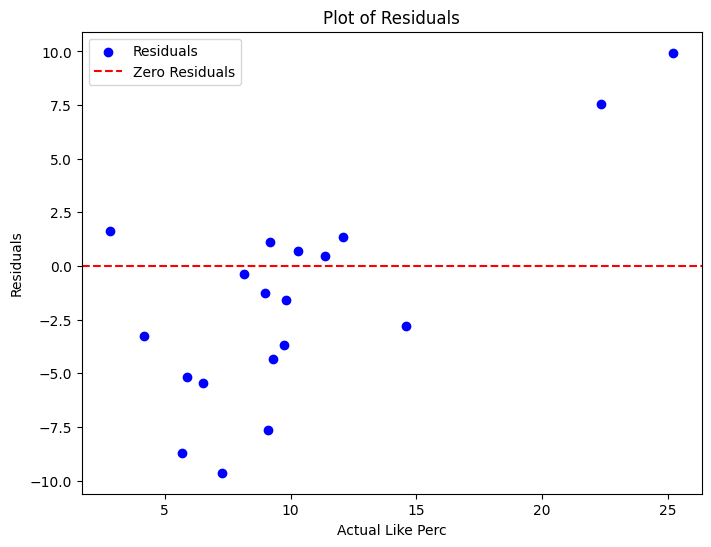

In [785]:
# Create a scatter plot of residuals
plt.figure(figsize=(8, 6))
plt.scatter(x=predictions_df['Actual_Like_Perc'], y=predictions_df['Residuals'], c='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Actual Like Perc')
plt.ylabel('Residuals')
plt.title('Plot of Residuals')
plt.legend()
plt.show()

#### Testing

In [ ]:
X_test.head()

In [ ]:
for column in list(X_test.columns)[:15]:
    print(column)

In [ ]:
print(f'{X_test.shape}')
print(f'\n')
print(f'{X_test.info()}')

In [ ]:
scoring_df

In [ ]:
for column in list(scoring_df.columns)[:25]:
    print(column)

In [ ]:
print(f'{scoring_df.shape}')
print(f'\n')
print(f'{scoring_df.info()}')

In [786]:
scoring_df['pred_like_perc'] = model.predict(scoring_df.drop(['like_count', 'username', 'image_url', 'post_date_utc', 'image_filename', 'like_perc', 'description', 'caption', 'bio'], axis=1))

scoring_df[['username', 'bio', 'followers_count', 'following_count', 'image_url', 'like_count', 'comment_count', 'caption', 'post_date_utc', 'like_perc', 'pred_like_perc']]

<ipython-input-786-9fafce02c9b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scoring_df['pred_like_perc'] = model.predict(scoring_df.drop(['like_count', 'username', 'image_url', 'post_date_utc', 'image_filename', 'like_perc', 'description', 'caption', 'bio'], axis=1))


,username,bio,followers_count,following_count,image_url,like_count,comment_count,caption,post_date_utc,like_perc,pred_like_perc
46,_nikhilnair_,25 vaffanculo,-0.657684,0.023016,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,163.0,-0.315852,vacay,2022-10-29 06:23:49,24.26,14.171893
45,_nikhilnair_,25 vaffanculo,-0.657684,0.023016,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,217.0,-0.201860,bbq business,2023-06-30 06:39:03,32.29,19.536786
44,_nikhilnair_,25 vaffanculo,-0.657684,0.023016,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,231.0,0.026123,atx ting,2023-08-01 05:51:45,34.38,27.528021
43,_nikhilnair_,25 vaffanculo,-0.657684,0.023016,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,226.0,-0.315852,santonio,2023-08-22 05:25:02,33.63,34.656071


## Single User Post Model

### Scraper

#### Setup

In [9]:
!pip install instaloader replicate

In [10]:
import os
import re
import json
import string
import random
import requests
import instaloader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import concurrent.futures

from google.colab import drive

from sqlite3 import OperationalError, connect

In [11]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Specify the path to the shell script file
script_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Others/env_vars.sh"

# Read the shell script file
with open(script_path) as file:
    script_content = file.readlines()

# Extract environment variables and assign them to os.environ
for line in script_content:
    if line.startswith("export "):
        key, value = line[len("export "):].strip().split("=")
        os.environ[key] = value.strip('"')

#### Login

In [13]:
def import_session(cookiefile, sessionfile):
    conn = connect(f"file:{cookiefile}?immutable=1", uri=True)
    try:
        cookie_data = conn.execute(
            "SELECT name, value FROM moz_cookies WHERE baseDomain='instagram.com'"
        )
    except OperationalError:
        cookie_data = conn.execute(
            "SELECT name, value FROM moz_cookies WHERE host LIKE '%instagram.com'"
        )
        loader = instaloader.Instaloader(max_connection_attempts=1, download_geotags=False, download_comments=False, download_videos=False, compress_json=False)
        loader.context._session.cookies.update(cookie_data)
        username = loader.test_login()
        if not username:
            raise SystemExit("Not logged in. Are you logged in successfully in Firefox?")
        loader.context.username = username
        loader.save_session_to_file(sessionfile)
    return loader, username

In [14]:
cookiefile = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Others/cookies.sqlite"
instaloaderr, username = import_session(cookiefile, None)
loader = instaloader.Instaloader()
loader.load_session_from_file(username)


HTTP redirect from https://www.instagram.com/graphql/query to https://www.instagram.com/challenge/?next=/graphql/query%253Fquery_hash%253Dd6f4427fbe92d846298cf93df0b937d3%2526variables%253D%25257B%25257D


ConnectionException: ignored

#### Usernames

In [ ]:
list_usernames = [
    '_silhouettte_', 'mllr_alex', 'joelwatkins.work', 'srinusagar123', 'ttikka5660', 'wimotheee', 'non_stop_arrow', 'polybius_arcade', '3dsp.ot', 'r45productions',
    '_nikhilnair_', '_trinity_king', 'withbhuv', 'dionsamuel_', 'desidiva', 'istenitk', 'maloneysdelights', 'meghna.deepak', 'lvsvs', 'kritzzzika2.0'
]

In [414]:
username = 'istenitk'

#### Profile Data

In [415]:
profile_info = []

try:
    # Load the profile
    print(f'Loading profile of @{username}...')
    profile = instaloader.Profile.from_username(loader.context, username)

    # Store the information in a dictionary
    profile_info.append({
        "username": username,
        "followers_count": profile.followers,
        "following_count": profile.followees,
        "bio": profile.biography,
        "is_verified": int(profile.is_verified)
    })

except Exception as e:
    print(f"Error retrieving information for {username}: {str(e)}")

Loading profile of @istenitk...


In [416]:
# Create a DataFrame from the profile_info dictionary
profile_info_df = pd.DataFrame(profile_info)
profile_info_df.head()

,username,followers_count,following_count,bio,is_verified
0,istenitk,2042,64,"The Indian Society for Technical Education, NI...",0


In [417]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_data.csv"
profile_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_data.csv


#### Profile Post Data

In [418]:
profile_post_info = []

try:
    # Load the profile
    print(f'Loading posts of @{username}...')
    profile = instaloader.Profile.from_username(loader.context, username)

    # Retrieve the required information for up to max_posts_per_username posts
    posts = []
    count = 0
    allposts = profile.get_posts()
    for post in allposts:
        if count >= 50 or post.date_utc < one_year_ago or post.likes < 0:
            break

        if post.caption is None:
            caption = ''
        else:
            caption = post.caption

        posts.append({
            "username": username,
            "image_url": post.url,
            "like_count": post.likes,
            "comment_count": post.comments,
            "caption": caption,
            "post_date_utc": post.date_utc,
            "post_type": "Video" if post.is_video else "Image",
            "num_hashtags": len([tag.strip("#") for tag in caption.split() if tag.startswith("#")]) if caption else 0,
            "num_mentions": len([mention.strip("@") for mention in caption.split() if mention.startswith("@")]) if caption else 0
        })

        count += 1

    profile_post_info.append(posts)

except Exception as e:
    print(f"Error retrieving information for {username}: {str(e)}")

Loading posts of @istenitk...


In [419]:
# Create a DataFrame from the profile_info dictionary
profile_post_info_flat_data = [item for sublist in profile_post_info for item in sublist]
profile_post_info_df = pd.DataFrame(profile_post_info_flat_data)
profile_post_info_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions
0,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,2,The wait is finally over ✨\n\nWith this year's...,2023-09-24 12:36:55,Image,0,0
1,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,211,4,Greetings to the batch of 2027 ✨\n\nWith 8 div...,2023-09-01 12:57:35,Video,5,0
2,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,401,4,"""Don't cry because it's over, smile because it...",2023-07-14 13:15:16,Image,6,0
3,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,137,0,It's that time of the year again🌟\n\nWe are gl...,2023-09-13 13:00:22,Image,4,0
4,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,153,0,🚀 Chandrayaan-3 Triumphs!\nISTE celebrates a w...,2023-08-30 13:04:23,Image,7,0


In [420]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data.csv"
profile_post_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data.csv


### Save Images

#### Load Data

In [421]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_data.csv"
profile_info_df = pd.read_csv(input_file)
profile_info_df = profile_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_info_df

,username,followers_count,following_count,bio,is_verified
0,istenitk,2042,64,"The Indian Society for Technical Education, NI...",0


In [422]:
print(f'{profile_info_df.shape}')
print(f'\n')
print(f'{profile_info_df.info()}')

(1, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   username         1 non-null      object
 1   followers_count  1 non-null      int64 
 2   following_count  1 non-null      int64 
 3   bio              1 non-null      object
 4   is_verified      1 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 168.0+ bytes
None


In [423]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data.csv"
profile_post_info_df = pd.read_csv(input_file)
profile_post_info_df = profile_post_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_post_info_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions
0,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,2,The wait is finally over ✨\n\nWith this year's...,2023-09-24 12:36:55,Image,0,0
1,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,211,4,Greetings to the batch of 2027 ✨\n\nWith 8 div...,2023-09-01 12:57:35,Video,5,0
2,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,401,4,"""Don't cry because it's over, smile because it...",2023-07-14 13:15:16,Image,6,0
3,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,137,0,It's that time of the year again🌟\n\nWe are gl...,2023-09-13 13:00:22,Image,4,0
4,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,153,0,🚀 Chandrayaan-3 Triumphs!\nISTE celebrates a w...,2023-08-30 13:04:23,Image,7,0


In [424]:
print(f'{profile_post_info_df.shape}')
print(f'\n')
print(f'{profile_post_info_df.info()}')

(50, 9)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       50 non-null     object
 1   image_url      50 non-null     object
 2   like_count     50 non-null     int64 
 3   comment_count  50 non-null     int64 
 4   caption        50 non-null     object
 5   post_date_utc  50 non-null     object
 6   post_type      50 non-null     object
 7   num_hashtags   50 non-null     int64 
 8   num_mentions   50 non-null     int64 
dtypes: int64(4), object(5)
memory usage: 3.6+ KB
None


#### Download Images to Folder

In [425]:
# Directory to save downloaded images
output_directory = r"/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single"

# Create the output directory if it doesn't exist or clear it if it does
if os.path.exists(output_directory):
    # Remove all files in the directory
    for filename in os.listdir(output_directory):
        file_path = os.path.join(output_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {str(e)}")
else:
    os.makedirs(output_directory)

In [426]:
# Function to download and save an image
def download_image(row, output_directory):
    username = row["username"]
    image_url = row["image_url"]
    index = row.name  # Get the index of the row

    filename = os.path.join(output_directory, f"{username}_{index}.jpg")

    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(filename, "wb") as image_file:
                image_file.write(response.content)
            return filename
        else:
            return None
    except Exception as e:
        print(f"Error downloading image for {username}: {str(e)}")
        return None

In [427]:
# Initialize a counter for each user
user_counters = {}

# Initialize new column for filename
profile_post_info_df["image_filename"] = None

# Use concurrent.futures to download images in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(download_image, row, output_directory) for _, row in profile_post_info_df.iterrows()]

# Update the DataFrame with downloaded image filenames
for future in concurrent.futures.as_completed(results):
    filename = future.result()
    if filename is not None:
        index = int(filename.split("_")[-1].split(".")[0])
        profile_post_info_df.at[index, "image_filename"] = filename
        print(f"Downloaded image: {filename}")

Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_36.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_12.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_7.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_20.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_32.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_30.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_42.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_14.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_4.jpg
Downloaded image: /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk

### Imports

In [428]:
import math
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

In [429]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess the text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Image Descriptions

In [430]:
import replicate

In [431]:
client = replicate.Client(api_token=os.environ["STABLEDIFFUSION_API_KEY"])

In [432]:
def generate_image_description(filepath):
    return client.run(
        "rmokady/clip_prefix_caption:9a34a6339872a03f45236f114321fb51fc7aa8269d38ae0ce5334969981e4cd8",
        input={"image": open(filepath, "rb")}
    )

In [433]:
# Initialize new column for description
profile_post_info_df["description"] = None

# Use concurrent.futures to generate descriptions in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for _, row in profile_post_info_df.iterrows():
        filepath = row["image_filename"]
        if filepath is not None:
            future = executor.submit(generate_image_description, filepath)
            futures.append(future)

    # Update the DataFrame with generated descriptions
    for future, (_, row) in zip(concurrent.futures.as_completed(futures), profile_post_info_df.iterrows()):
        description = future.result()
        if description is not None:
            profile_post_info_df.at[row.name, "description"] = description
            print(f"Generated description for {row['image_filename']}: {description}")

Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_0.jpg: A picture of a turtle sitting on a blue chair.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_1.jpg: A picture of a blue and white clock with a white face.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_2.jpg: A couple of yellow plastic chairs sitting on top of a floor.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_3.jpg: A white board with a picture of a woman holding a blue sign.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_4.jpg: A television show showing a woman on a platform with a laptop.
Generated description for /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/img_single/istenitk_5.jpg: A large group of people posing for a picture.
Generated des

In [434]:
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data_w_desc.csv"
profile_post_info_df.to_csv(csv_file_path)
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data_w_desc.csv


### Data Loading and Cleaning

In [435]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_post_data_w_desc.csv"
profile_post_info_df = pd.read_csv(input_file)
profile_post_info_df = profile_post_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_post_info_df = profile_post_info_df[profile_post_info_df['like_count']!=-1.0]
profile_post_info_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,post_type,num_hashtags,num_mentions,image_filename,description
0,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,2,The wait is finally over ✨\n\nWith this year's...,2023-09-24 12:36:55,Image,0,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A picture of a turtle sitting on a blue chair.
1,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,211,4,Greetings to the batch of 2027 ✨\n\nWith 8 div...,2023-09-01 12:57:35,Video,5,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A picture of a blue and white clock with a whi...
2,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,401,4,"""Don't cry because it's over, smile because it...",2023-07-14 13:15:16,Image,6,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A couple of yellow plastic chairs sitting on t...
3,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,137,0,It's that time of the year again🌟\n\nWe are gl...,2023-09-13 13:00:22,Image,4,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A white board with a picture of a woman holdin...
4,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,153,0,🚀 Chandrayaan-3 Triumphs!\nISTE celebrates a w...,2023-08-30 13:04:23,Image,7,0,/content/drive/MyDrive/Colab Notebooks/2. Fall...,A television show showing a woman on a platfor...


In [436]:
# Load the previously saved CSV data
input_file = "/content/drive/MyDrive/Colab Notebooks/2. Fall/UD/Insta/instagram_profile_single_data.csv"
profile_info_df = pd.read_csv(input_file)
profile_info_df = profile_info_df.drop(columns=["Unnamed: 0"], axis=1)
profile_info_df.head()

,username,followers_count,following_count,bio,is_verified
0,istenitk,2042,64,"The Indian Society for Technical Education, NI...",0


In [437]:
final_df = pd.merge(profile_post_info_df, profile_info_df, on='username', how='left')
# final_df.head()

In [438]:
# Remove NaN values from the "location" colum
def extract_name(location):
    if isinstance(location, str):
        match = re.search(r"name='(.*?)'", location)
        if match:
            return match.group(1).lower()
    return ''

## Clean text
def preprocess_text(text):
    if text is None:
        return ''

    # Convert to string if not already
    if not isinstance(text, str):
        text = str(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and lemmatize
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum() and word.lower() not in stop_words]

    return ' '.join(words)

# Weight likes by followers
final_df['like_perc'] = round((final_df['like_count']/final_df['followers_count'])*100, 2)

# Convert post_date_utc to datetime and extract relevant features
final_df['post_date_utc'] = pd.to_datetime(final_df['post_date_utc'])
final_df['hour_of_day'] = final_df['post_date_utc'].dt.hour
final_df['day_of_week'] = final_df['post_date_utc'].dt.dayofweek

# Create a new 'image' column with 1 for 'image' and 0 otherwise
final_df['is_image'] = (final_df['post_type'] == 'Image').astype(int)
final_df.drop(columns=['post_type'], inplace=True)

## Pre process text
final_df['caption'] = final_df['caption'].apply(preprocess_text)
final_df['description'] = final_df['description'].apply(preprocess_text)
final_df['bio'] = final_df['bio'].apply(preprocess_text)

# Scale columns
scaler = StandardScaler()
columns_to_scale = ['comment_count', 'num_hashtags', 'num_mentions']
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])

In [439]:
final_df

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified,like_perc,hour_of_day,day_of_week,is_image
0,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,0.971014,wait finally year gruelling recruitment proces...,2023-09-24 12:36:55,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture turtle sitting blue chair,2042,64,indian society technical education nitk engine...,0,9.35,12,6,1
1,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,211,2.420290,greeting batch 2027 8 diverse specific interes...,2023-09-01 12:57:35,-0.378114,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture blue white clock white face,2042,64,indian society technical education nitk engine...,0,10.33,12,4,0
2,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,401,2.420290,dont cry smile happened dr past year istenitk ...,2023-07-14 13:15:16,-0.179107,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,couple yellow plastic chair sitting top floor,2042,64,indian society technical education nitk engine...,0,19.64,13,4,1
3,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,137,-0.478261,time year glad announce iste nitk recruiting e...,2023-09-13 13:00:22,-0.577122,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,white board picture woman holding blue sign,2042,64,indian society technical education nitk engine...,0,6.71,13,2,1
4,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,153,-0.478261,chandrayaan3 triumph iste celebrates week chan...,2023-08-30 13:04:23,0.019901,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,television show showing woman platform laptop,2042,64,indian society technical education nitk engine...,0,7.49,13,2,1
5,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,86,-0.478261,empowering woman one session iste joined force...,2023-08-18 12:35:17,-0.179107,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,large group people posing picture,2042,64,indian society technical education nitk engine...,0,4.21,12,4,1
6,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,104,-0.478261,success preparation opportunity meet bobby uns...,2023-07-19 15:30:21,0.019901,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,woman sitting chair man,2042,64,indian society technical education nitk engine...,0,5.09,15,2,1
7,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,78,-0.478261,official record fail capture essence life time...,2023-07-17 13:00:32,0.019901,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,sign read telling truth torture sits table,2042,64,indian society technical education nitk engine...,0,3.82,13,0,1
8,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,137,-0.478261,fortnight flair endure every stride illuminate...,2023-07-01 12:33:27,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture woman bridge tube,2042,64,indian society technical education nitk engine...,0,6.71,12,5,1
9,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,83,-0.478261,18th june iste nitk brought neha agarwal visio...,2023-06-25 12:50:50,-0.179107,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,book computer table,2042,64,indian society technical education nitk engine...,0,4.06,12,6,1


In [440]:
# Calculate the mean and standard deviation of 'like_perc'
mean_like_perc = final_df['like_perc'].mean()
std_like_perc = final_df['like_perc'].std()

# Filter the DataFrame to keep rows within the mean plus 2 standard deviations
final_df = final_df[(final_df['like_perc'] >= mean_like_perc - 1.5 * std_like_perc) & (final_df['like_perc'] <= mean_like_perc + 1.5 * std_like_perc)]

In [441]:
user_final_df2 = final_df.copy()

# Make sure your dataframe is named df
user_final_df2['post_date_utc'] = pd.to_datetime(user_final_df2['post_date_utc'])
user_final_df2 = user_final_df2.groupby('username', group_keys=False).apply(lambda x: x.sort_values('post_date_utc', ascending=True))
user_final_df2['time_decay_factor'] = np.nan

# Define the decay factor function
def calculate_decay_factor(group):
    n = len(group)
    lam = 0.1
    group['time_decay_factor'] = [math.exp(-lam * i) for i in range(n)][::-1]
    # group['time_decay_factor'] = [1 - math.exp(-lam * (n - i)) for i in range(n)]
    return group

# Apply the decay factor for each username group
user_final_df2 = user_final_df2.groupby('username', group_keys=False).apply(calculate_decay_factor)
user_final_df2['weighted_like_perc'] = user_final_df2['like_perc'] * user_final_df2['time_decay_factor']
# user_final_df2

In [442]:
user_final_df2.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,followers_count,following_count,bio,is_verified,like_perc,hour_of_day,day_of_week,is_image,time_decay_factor,weighted_like_perc
49,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,199,-0.478261,high low stock market intrigue buckle iste nit...,2023-03-11 17:45:38,1.611960,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,table clock sign read journal behavioural neur...,2042,64,indian society technical education nitk engine...,0,9.75,17,5,1,0.010052,0.098005
48,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,197,-0.478261,going 100 1000 going going gone iste credit pr...,2023-03-11 17:50:28,2.009975,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front tv screen,2042,64,indian society technical education nitk engine...,0,9.65,17,5,1,0.011109,0.107202
47,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,115,-0.478261,let raise voice break silence around mental he...,2023-03-22 14:05:59,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture microphone used talk crowd,2042,64,indian society technical education nitk engine...,0,5.63,14,2,1,0.012277,0.069121
46,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,120,-0.478261,exciting news official website iste nitk revam...,2023-03-23 14:29:56,0.616923,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,table computer bunch wire,2042,64,indian society technical education nitk engine...,0,5.88,14,3,1,0.013569,0.079783
45,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,105,-0.478261,hey fellow techie curious ready dive exciting ...,2023-03-25 13:15:09,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,blue white laptop computer tile floor,2042,64,indian society technical education nitk engine...,0,5.14,13,5,1,0.014996,0.077077


### Vectorize Text

In [443]:
# Initialize TF-IDF Vectorizers for each column
feature_size = 128
tfidf_description = TfidfVectorizer(max_features=feature_size)
tfidf_caption = TfidfVectorizer(max_features=feature_size)

# Fit and transform each TF-IDF Vectorizer on its respective column
tfidf_description_matrix = tfidf_description.fit_transform(user_final_df2['description'])
tfidf_caption_matrix = tfidf_caption.fit_transform(user_final_df2['caption'])

# Convert the TF-IDF matrices to DataFrames
tfidf_description_df = pd.DataFrame(tfidf_description_matrix.toarray(), columns=[f'desc_{i}' for i in range(tfidf_description_matrix.shape[1])])
tfidf_caption_df = pd.DataFrame(tfidf_caption_matrix.toarray(), columns=[f'caption_{i}' for i in range(tfidf_caption_matrix.shape[1])])

#Set index of new DataFrame as original DataFrame
tfidf_description_df.index = user_final_df2.index
tfidf_caption_df.index = user_final_df2.index

# Concatenate the original DataFrame with the TF-IDF DataFrames
cleaned_final_df = pd.concat([user_final_df2, tfidf_description_df, tfidf_caption_df], axis=1)
# cleaned_final_df

### Splitting

In [444]:
scoring_size = 1

In [445]:
scoring_df = cleaned_final_df.tail(scoring_size).copy()
scoring_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,...,caption_118,caption_119,caption_120,caption_121,caption_122,caption_123,caption_124,caption_125,caption_126,caption_127
0,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,0.971014,wait finally year gruelling recruitment proces...,2023-09-24 12:36:55,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture turtle sitting blue chair,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255938


In [446]:
final_main_df = cleaned_final_df.iloc[:-scoring_size].copy()
final_main_df.head()

,username,image_url,like_count,comment_count,caption,post_date_utc,num_hashtags,num_mentions,image_filename,description,...,caption_118,caption_119,caption_120,caption_121,caption_122,caption_123,caption_124,caption_125,caption_126,caption_127
49,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,199,-0.478261,high low stock market intrigue buckle iste nit...,2023-03-11 17:45:38,1.611960,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,table clock sign read journal behavioural neur...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
48,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,197,-0.478261,going 100 1000 going going gone iste credit pr...,2023-03-11 17:50:28,2.009975,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,man standing front tv screen,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
47,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,115,-0.478261,let raise voice break silence around mental he...,2023-03-22 14:05:59,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,picture microphone used talk crowd,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
46,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,120,-0.478261,exciting news official website iste nitk revam...,2023-03-23 14:29:56,0.616923,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,table computer bunch wire,...,0.0,0.0,0.0,0.0,0.0,0.880051,0.0,0.000000,0.0,0.0
45,istenitk,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,105,-0.478261,hey fellow techie curious ready dive exciting ...,2023-03-25 13:15:09,-1.373151,-0.142857,/content/drive/MyDrive/Colab Notebooks/2. Fall...,blue white laptop computer tile floor,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.214065,0.0,0.0


In [447]:
for col in list(final_main_df.columns)[:20]:
  print(col)

username
image_url
like_count
comment_count
caption
post_date_utc
num_hashtags
num_mentions
image_filename
description
followers_count
following_count
bio
is_verified
like_perc
hour_of_day
day_of_week
is_image
time_decay_factor
weighted_like_perc


In [448]:
# Concatenate all DataFrames
X = final_main_df.drop(['like_count', 'username', 'image_url', 'post_date_utc', 'image_filename', 'like_perc', 'weighted_like_perc', 'description', 'caption', 'bio', 'followers_count', 'following_count', 'is_verified'], axis=1)
y = final_main_df['weighted_like_perc']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.head()

,comment_count,num_hashtags,num_mentions,hour_of_day,day_of_week,is_image,time_decay_factor,desc_0,desc_1,desc_2,...,caption_118,caption_119,caption_120,caption_121,caption_122,caption_123,caption_124,caption_125,caption_126,caption_127
6,-0.478261,0.019901,-0.142857,15,2,1,0.606531,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
45,-0.478261,-1.373151,-0.142857,13,5,1,0.014996,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.214065,0.0,0.0
36,-0.478261,-1.373151,-0.142857,15,4,1,0.033373,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.243663,0.0,0.0
40,-0.478261,0.417916,-0.142857,12,3,1,0.022371,0.0,0.0,0.0,...,0.0,0.139404,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
46,-0.478261,0.616923,-0.142857,14,3,1,0.013569,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.880051,0.0,0.000000,0.0,0.0


### Models

In [449]:
# Define the XGBoost model
xgb_model = XGBRegressor()

# Define the hyperparameter grid for GridSearch
param_grid = {
    'n_estimators': [300, 250],
    'learning_rate': [0.3, 0.2],
    'max_depth': [4, 3],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=6, scoring='neg_root_mean_squared_error', verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 2)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 6 folds for each of 8 candidates, totalling 48 fits
Mean Squared Error (MSE): 2.698644469948344
Root Mean Squared Error (RMSE): 1.642755146072702
Mean Absolute Error (MAE): 1.1901109680302229
R-squared (R2) Score: 0.7112020346368144
Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 300}


In [410]:
# Define the Lasso model
lasso_model = Lasso(max_iter=10000)

# Define the hyperparameter grid for GridSearch
param_grid = {
    'alpha': [0.01, 0.05, 0.06, 0.1, 0.3, 1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 2)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")
print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Mean Squared Error (MSE): 5.125769069534286
Root Mean Squared Error (RMSE): 2.264016137207128
Mean Absolute Error (MAE): 2.2097456225440935
R-squared (R2) Score: -20.111653191356
Best hyperparameters: {'alpha': 0.1}


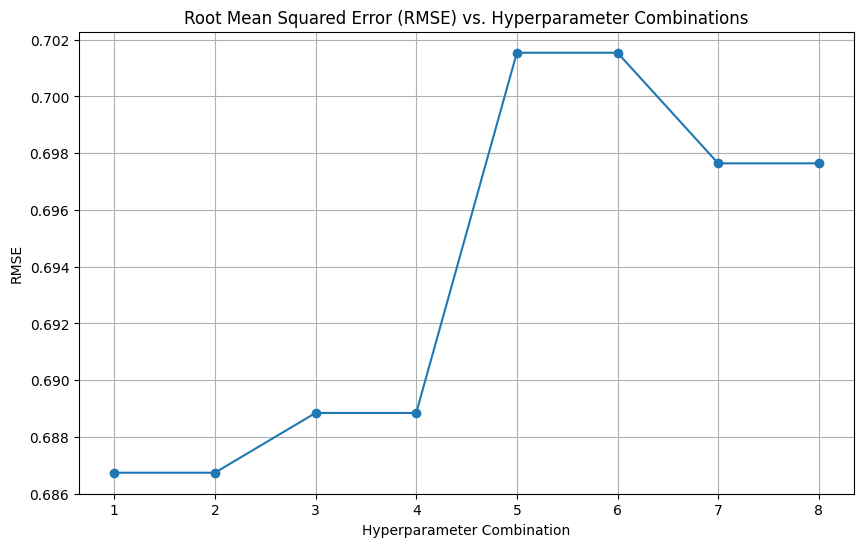

In [450]:
# Extract RMSE values during grid search
rmse_values = np.sqrt(-grid_search.cv_results_['mean_test_score'])

# Plot RMSE values for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values)), rmse_values, marker='o', linestyle='-')
plt.title("Root Mean Squared Error (RMSE) vs. Hyperparameter Combinations")
plt.xlabel("Hyperparameter Combination")
plt.ylabel("RMSE")
plt.xticks(range(len(rmse_values)), range(1, len(rmse_values) + 1))
plt.grid(True)
plt.show()

### Prediction

In [451]:
# Create a new DataFrame for predictions
predictions_df = pd.DataFrame({'Actual_Like_Perc': y_test, 'Predicted_Like_Perc': y_pred})

# Convert predicted values from scientific notation to regular numbers
predictions_df['Actual_Like_Perc'] = predictions_df['Actual_Like_Perc']
predictions_df['Predicted_Like_Perc'] = predictions_df['Predicted_Like_Perc']

predictions_df['Residuals'] = predictions_df['Actual_Like_Perc'] - predictions_df['Predicted_Like_Perc']

predictions_df

,Actual_Like_Perc,Predicted_Like_Perc,Residuals
8,3.332087,1.64,1.692087
22,0.641672,0.64,0.001672
21,0.351872,0.94,-0.588128
1,8.457489,5.29,3.167489
12,0.848821,1.35,-0.501179


### Testing

#### Test

In [452]:
scoring_df['pred_like_perc'] = model.predict(scoring_df.drop(['like_count', 'username', 'image_url', 'post_date_utc', 'image_filename', 'like_perc', 'weighted_like_perc', 'description', 'caption', 'bio', 'followers_count', 'following_count', 'is_verified'], axis=1))

scoring_df[['username', 'bio', 'followers_count', 'following_count', 'image_url', 'like_count', 'comment_count', 'caption', 'post_date_utc', 'like_perc', 'pred_like_perc']]

,username,bio,followers_count,following_count,image_url,like_count,comment_count,caption,post_date_utc,like_perc,pred_like_perc
0,istenitk,indian society technical education nitk engine...,2042,64,https://instagram.fmaa10-1.fna.fbcdn.net/v/t51...,191,0.971014,wait finally year gruelling recruitment proces...,2023-09-24 12:36:55,9.35,5.818528
